# Merge the prophage counts based on the host's taxonomy

We are going to use the [GTDB](https://gtdb.ecogenomic.org/) taxonomy to count the number of prophages at different levels. Because of this, we merge with the GTDB metadata file.

In [4]:
# A lot of this is not used, but we import it so we have it later!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

import pandas as pd
import seaborn as sns
import numpy as np

import math
import re
import string
from PhiSpyAnalysis import theils_u, DateConverter, read_phages, read_gtdb, read_checkv

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA


import subprocess
import gzip


# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black", end="\n"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [5]:
phagesdf = read_phages()
phagesdf

Please note that this was run with git commit 7b76a50 that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages,but after filtering we kept 1,293,084 prophages from 176,705 genomes

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
438,GCA_000143005.1,ASM14300v1,6230104.0,3012.0,90.0,41.0,4.0,15.0,22.0,93028.0
447,GCA_000143625.1,ASM14362v1,2067400.0,173.0,40.0,17.0,3.0,3.0,11.0,79747.0
536,GCA_000145685.1,ASM14568v1,6005667.0,463.0,98.0,45.0,6.0,10.0,29.0,115819.0
538,GCA_000145745.1,ASM14574v1,6091697.0,445.0,65.0,45.0,6.0,14.0,25.0,144737.0
539,GCA_000145765.1,ASM14576v1,6506028.0,2281.0,63.0,52.0,6.0,15.0,31.0,145984.0
...,...,...,...,...,...,...,...,...,...,...
567389,GCA_904848645.1,LMG_24235,9749118.0,161.0,84.0,48.0,5.0,25.0,18.0,167790.0
567394,GCA_905184115.1,Burkholderia_sp._ABIP444_draft_genome,7379939.0,292.0,210.0,59.0,8.0,23.0,28.0,168534.0
567398,GCA_905176665.1,D4_OalgB6SA,5465468.0,286.0,71.0,10.0,0.0,10.0,0.0,0.0
567399,GCA_905176675.1,G3_OalgB6SA,4272394.0,1048.0,179.0,11.0,0.0,9.0,2.0,0.0


### Read the data file

The metadata is from GTDB. The phage data is from us.


In [6]:
gtdb = read_gtdb()
gtdb

,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
0,GB_GCA_000006155.2,1916,93.12,0.00,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,...,NaN,NaN,NaN,NaN,NaN,NaN,42300,16,31,0
1,GB_GCA_000007385.1,0,99.82,0.00,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,...,1541.0,2846.0,0.0,100.000,JXEG01000201.4293.5839,Bacteria;Proteobacteria;Gammaproteobacteria;Xa...,0,20,53,0
2,GB_GCA_000008605.1,67,100.00,0.00,235,f__Spirochaetaceae (UID2512),124,0.0,1048744,92.155875,...,1545.0,2854.0,0.0,100.000,CP003679.231299.232859,Bacteria;Spirochaetes;Spirochaetia;Spirochaeta...,0,20,45,0
3,GB_GCA_000010565.1,0,100.00,0.63,295,p__Firmicutes (UID1022),158,0.0,2608397,86.217312,...,1526.0,2819.0,0.0,100.000,AP009389.1049070.1050595,Bacteria;Firmicutes;Clostridia;Clostridiales;P...,0,20,51,1
4,GB_GCA_000013845.2,0,100.00,0.00,332,o__Clostridiales (UID1375),124,0.0,2428396,82.037966,...,1509.0,2787.0,0.0,100.000,CP000312.233320.234832,Bacteria;Firmicutes;Clostridia;Clostridiales;C...,0,20,95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191522,RS_GCF_902166935.1,0,99.62,0.09,1312,g__Klebsiella (UID5140),336,0.0,4894244,87.293148,...,1536.0,2837.0,0.0,100.000,MAPL01000082.143.1696,Bacteria;Proteobacteria;Gammaproteobacteria;En...,0,20,87,1
191523,RS_GCF_902166945.1,0,99.94,0.72,1162,f__Enterobacteriaceae (UID5121),336,0.0,5162721,86.540042,...,1536.0,2837.0,0.0,100.000,CP016813.16076.17629,Bacteria;Proteobacteria;Gammaproteobacteria;En...,0,20,86,1
191524,RS_GCF_902167295.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5737447,90.122088,...,1490.0,2747.0,0.0,99.933,JX101438.1.1490,Bacteria;Bacteroidetes;Bacteroidia;Chitinophag...,0,20,58,0
191525,RS_GCF_902167305.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5738096,90.147873,...,1490.0,2747.0,0.0,99.933,JX101438.1.1490,Bacteria;Bacteroidetes;Bacteroidia;Chitinophag...,0,20,58,0


### Abstract out the accession and name into new columns

This will allow us to merge the data with the PATRIC and GTDB data

In [7]:
acccol = 'assembly_accession'

## Sanity check

This is just to make sure that we are all working on the same data. Here, we make a temporary data frame that has the number of contigs and the number of basepairs in the genome, and use those to compare to see if we think we are working on the same thing.

If we find columns that are no good, we should delete them (but we don't, yay!)

In [8]:
def are_same(x):
    # currently fixing contig counts, so when that is done delete the next line and uncomment the one after
    return x['genome_size'] == x['Genome length']
    # return x['genome_size'] == x['Genome length'] and x['contig_count'] == x['Contigs']

comparison = pd.merge(gtdb[[acccol, 'contig_count', 'genome_size']],
                      phagesdf[[acccol, 'Contigs', 'Genome length']],
                      how='inner', left_on=acccol, right_on=acccol)

comparison['same'] = comparison.apply(are_same, axis=1)
# look for rows that are not the same
comparison[comparison['same']==False]

,assembly_accession,contig_count,genome_size,Contigs,Genome length,same


## Filter the genomes

We should probably filter out based on quality. We have three quality scores (mimag high/medium/low) plus the number of contigs. Lets make a little violin plot of the quality vs Total or Kept prophages.


In [9]:
qual = pd.merge(gtdb[[acccol, 'checkm_completeness', 'gc_percentage', 'contig_count', 'genome_size', 'mimag_high_quality', 'mimag_low_quality', 'mimag_medium_quality']],
                phagesdf[[acccol, 'Total Predicted Prophages', 'Kept']],
                how='inner', left_on=acccol, right_on=acccol)
qual

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept
0,GCA_000154925.1,75.30,71.058046,597,6941735,f,f,t,43.0,3.0
1,GCA_000167215.1,97.93,35.247241,207,5934942,f,f,t,55.0,3.0
2,GCA_000167695.1,85.31,35.035707,867,5880839,f,f,t,41.0,9.0
3,GCA_000167775.1,97.76,35.504006,393,2205442,t,f,f,22.0,1.0
4,GCA_000167795.1,98.87,35.594162,345,2201150,f,f,t,21.0,2.0
...,...,...,...,...,...,...,...,...,...,...
38720,GCA_901830425.1,99.46,46.481358,316,3027945,f,f,t,19.0,3.0
38721,GCA_901830435.1,99.07,44.210009,160,3552900,t,f,f,24.0,4.0
38722,GCA_901971765.1,99.45,39.047534,180,2113987,t,f,f,8.0,0.0
38723,GCA_902141845.1,99.00,70.084154,247,6086597,t,f,f,43.0,4.0


In [10]:
def mimag_qual(x):
    if x['mimag_high_quality'] == 't':
        return "High"
    if x['mimag_medium_quality'] == 't':
        return "Medium"
    if x['mimag_low_quality'] == 't':
        return "Low"
    return "Unknown"

qual['Mimag quality'] = qual.apply(mimag_qual, axis=1)
qual

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept,Mimag quality
0,GCA_000154925.1,75.30,71.058046,597,6941735,f,f,t,43.0,3.0,Medium
1,GCA_000167215.1,97.93,35.247241,207,5934942,f,f,t,55.0,3.0,Medium
2,GCA_000167695.1,85.31,35.035707,867,5880839,f,f,t,41.0,9.0,Medium
3,GCA_000167775.1,97.76,35.504006,393,2205442,t,f,f,22.0,1.0,High
4,GCA_000167795.1,98.87,35.594162,345,2201150,f,f,t,21.0,2.0,Medium
...,...,...,...,...,...,...,...,...,...,...,...
38720,GCA_901830425.1,99.46,46.481358,316,3027945,f,f,t,19.0,3.0,Medium
38721,GCA_901830435.1,99.07,44.210009,160,3552900,t,f,f,24.0,4.0,High
38722,GCA_901971765.1,99.45,39.047534,180,2113987,t,f,f,8.0,0.0,High
38723,GCA_902141845.1,99.00,70.084154,247,6086597,t,f,f,43.0,4.0,High


In [11]:
qual[qual['Mimag quality'] == 'Unknown']

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept,Mimag quality
268,GCA_000448165.1,96.05,51.522661,127,2260155,f,f,f,37.0,3.0,Unknown
346,GCA_000682315.1,99.32,39.005359,589,4635745,f,f,f,99.0,5.0,Unknown
417,GCA_000954095.1,96.17,35.753954,656,3145901,f,f,f,26.0,0.0,Unknown
1433,GCA_002115415.1,97.13,37.652163,156,3329167,f,f,f,41.0,4.0,Unknown
1547,GCA_002256295.1,99.14,36.376408,180,4244075,f,f,f,29.0,1.0,Unknown
2197,GCA_002732875.1,73.03,46.446780,207,2989238,f,f,f,85.0,1.0,Unknown
6435,GCA_900686955.1,100.00,28.829301,335,5928556,f,f,f,61.0,9.0,Unknown
7188,GCA_000295775.2,100.00,50.399006,276,5540893,f,f,f,51.0,7.0,Unknown
7291,GCA_000312625.1,98.28,47.788664,161,2355793,f,f,f,18.0,0.0,Unknown
8038,GCA_000412595.1,94.85,42.648446,278,5454996,f,f,f,88.0,1.0,Unknown


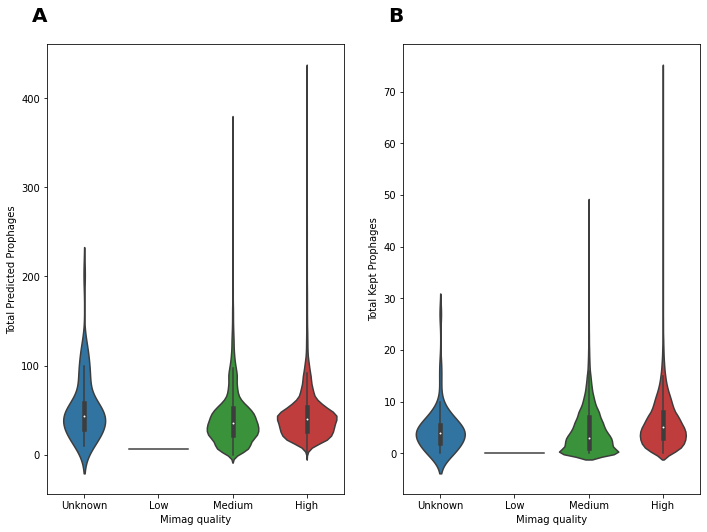

In [12]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.violinplot(x='Mimag quality', y='Total Predicted Prophages', jitter=True, data=qual, ax=ax[0], order=['Unknown', 'Low', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Total Predicted Prophages',  jitter=True, data=qual, alpha=0.1, ax=ax[0], color='k')

sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax[1], order=['Unknown', 'Low', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax[1])
ax[1].set_ylabel("Total Kept Prophages")

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

plt.show()


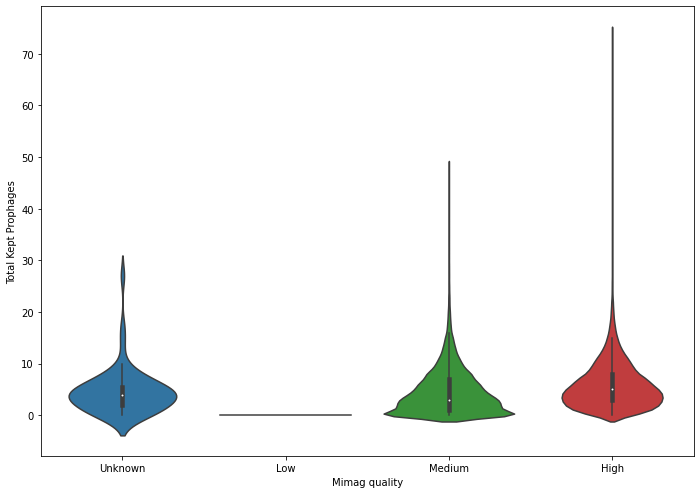

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax, order=['Unknown', 'Low', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax[1])
ax.set_ylabel("Total Kept Prophages")

plt.show()

### How does completeness/size compare with predictions?

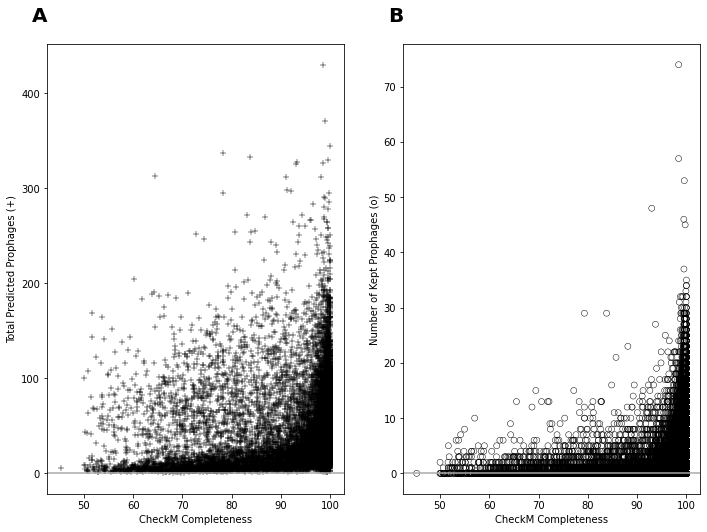

In [16]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='checkm_completeness', y='Total Predicted Prophages', data=qual, marker='+', color='k', ax=ax[0])
sns.scatterplot(x='checkm_completeness', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
# ax2.grid(False)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('CheckM Completeness')
ax[1].set_xlabel('CheckM Completeness')
ax[0].axhline(y=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

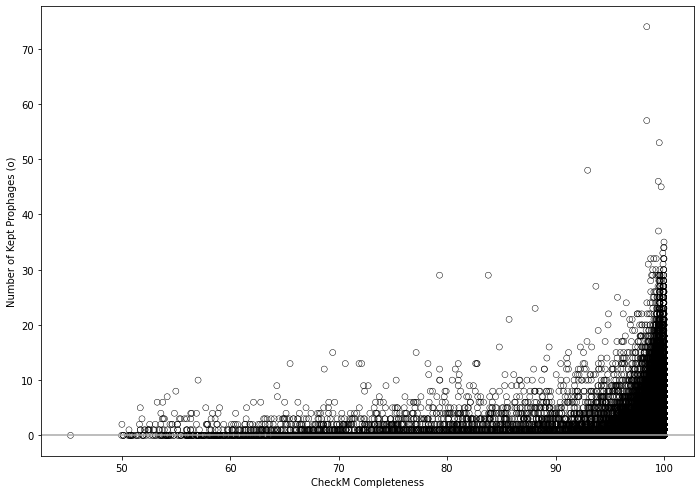

In [18]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.scatterplot(x='checkm_completeness', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax)
ax.set_ylabel('Number of Kept Prophages (o)')
ax.set_xlabel('CheckM Completeness')
ax.axhline(y=0, color='darkgrey')

fig.savefig("images/checkm_vs_phages.svg")

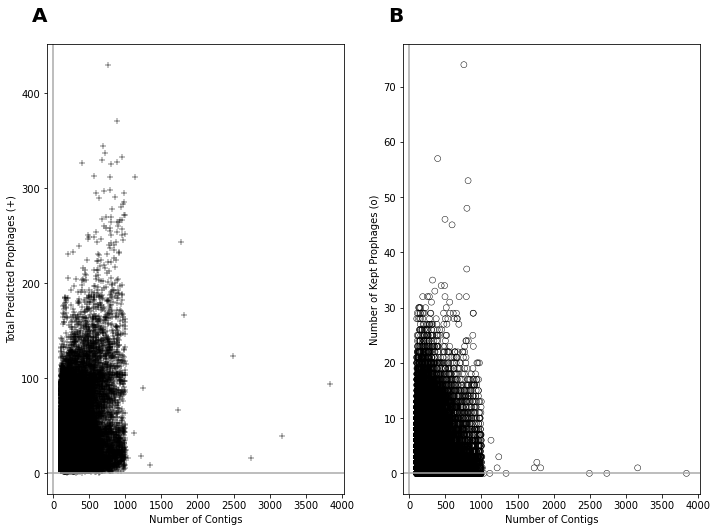

In [11]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])

ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

fig.savefig("images/contigs_vs_phages.svg")


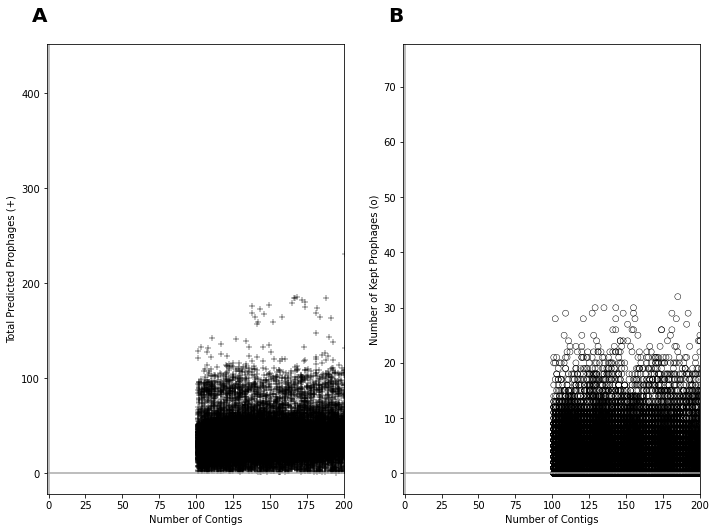

In [12]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
ax[0].set_xlim(-1,200)
ax[1].set_xlim(-1,200)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')


for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

fig.savefig("images/contigs_vs_phages_0200.svg")

At the moment there doesn't seem to be an obvious reason to cut or cull any of these predictions!

# Compare CheckM and CheckV

See if high/medium/low phage genomes correlate with other predictions?

In [2]:
checkv = read_checkv()
checkv

,prophage,contig_length,gene_count,checkv_quality
0,FP103042.2_PP1,16370,24,Not-determined
1,FP103042.2_PP2,36505,43,Not-determined
2,FP103042.2_PP3,29150,31,Not-determined
3,FP103042.2_PP4,15259,17,Low-quality
4,FP103042.2_PP5,31780,39,Low-quality
...,...,...,...,...
3210638,CADIKL010000006.1_PP1,49842,74,High-quality
3210639,CADIKN010000004.1_PP1,28004,30,Not-determined
3210640,CADIKN010000013.1_PP2,25483,29,Low-quality
3210641,CADIKP010000001.1_PP1,46907,76,High-quality


In [ ]:
counts = {}
for index, rows in checkv.iterrows():
    if rows['assembly_accession'] not in counts:
        counts[rows['assembly_accession']] = {}
    counts[rows['assembly_accession']][rows['checkv_quality']] = counts[rows['assembly_accession']].get(rows['checkv_quality'], 0) + 1
checkvcounts = pd.DataFrame.from_dict(counts).T
checkvcounts = checkvcounts.reset_index().rename(columns={"index" : "assembly_accession"})
checkvcounts

In [ ]:
checkmv = pd.merge(gtdb[['assembly_accession', 'checkm_completeness']], checkvcounts, left_on='assembly_accession', right_on='assembly_accession', how='inner')
checkmv

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    sns.scatterplot(x='checkm_completeness', y=c, data=checkmv, marker='o', ax=ax, label=c, alpha=0.6)

ax.set_ylabel('Number of prophages')
ax.set_xlabel('Genome Completeness (CheckM)')
ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
l.set_title("Prophage Quality (CheckV)")

# Taxonomy

Extract the taxonomy from the GTDB table

### Split the taxonomy into separate columns

We split on `_` but unfortunately the `_` means something specific in GTDB. This is taken from the [FAQ](https://gtdb.ecogenomic.org/faq)
> If the organism had been assigned a binomial species name such as Prevotella oralitaxus str. F0040, and it is not part of true Prevotella in GTDB, we would assign it to the placeholder genus g__Prevotella_A to indicate it is not a true Prevotella species, but that there are representative genomes that have been assigned to a species

We at least remove the `g__` at the beginning and then leave the appendages.

In [ ]:
s = re.compile('^.__')
# u = re.compile('_')
def split_taxonomy(x):
    p  = x.split(';')
    if len(p) != 7:
        sys.stderr.write("We have {len(p)} fields in {x}, but we expected 7 fields")
    # remove the prepended taxonomic rank name (e.g d__) and any remaining underscores before returning.
    # return [u.sub(' ', l) for l in [s.sub('', m) for m in p] ]
    return [s.sub('', m) for m in p]

In [ ]:
# this is an example to make sure the split looks good. Returns an array
split_taxonomy(gtdb['gtdb_taxonomy'].iloc[0])

In [ ]:
tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
gc = ['accession', 'gtdb_genome_representative', 'gtdb_representative', 'gtdb_taxonomy', 'gtdb_type_designation', 'gtdb_type_designation_sources', 'gtdb_type_species_of_genus']
gtdbex = pd.concat([gtdb[acccol], pd.DataFrame.from_records(gtdb['gtdb_taxonomy'].apply(split_taxonomy), columns=tc), gtdb[gc]], axis=1)
gtdbex

### Do we need to combine to different levels

We can combined e.g. from Bacteria to Order. But do we need to?

In [ ]:
toorder = len(pd.unique(gtdbex.apply(lambda x: '_'.join(x[1:5].values.tolist()), axis=1)))
uniqueorder = len(pd.unique(gtdbex['order']))
print(f"Unique orders: {uniqueorder} Unique to order: {toorder}")

[According to Donovan, they should be unique](https://forum.gtdb.ecogenomic.org/t/uniqueness-of-names-across-the-taxonomy/137) so we don't need to merge the columns! 

## Merge the data frames

Merge the GTDB taxonomy with the prophage counts into a single df

In [ ]:
cvtax = pd.merge(gtdbex[['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']], checkvcounts, left_on='assembly_accession', right_on='assembly_accession', how='inner')
cvtax = pd.merge(cvtax, phagesdf[['assembly_accession', 'Kept']], left_on='assembly_accession', right_on='assembly_accession', how='inner')
cvtax

In [ ]:
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    print(cvtax[c].mean())

### Make a plot

This makes a plot of the data, and sets the labels to be readable.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54), sharey=True)
sns.barplot(x='phylum', y='Kept', data=cvtax, ax=ax, label=c, color=sns.color_palette("colorblind")[0], estimator=sum)

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
ax.set_title(f"Total number of prophages per phyla")

# add a slight offset for every other tick label
"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Total number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phylaTotal.svg')

In [ ]:
tx = "**Fig. S\*\* Phages predicted per bacterial phyla.** Most of the predictions are from"
for idx, row in cvtax.groupby('phylum').sum().sort_values(by='Kept', ascending=False).head(5).iterrows():
    tx += f" {idx} ({int(row['Kept']):,} phages),"
printmd(tx)


In [ ]:
fig, axes = plt.subplots(2,2, figsize=(23.4,16.54), sharey=True)

col =  [['Not-determined', 'Low-quality'], ['Medium-quality', 'High-quality']]

for i in 0, 1:
    for j in 0, 1:
        c = col[i][j]
        ax = axes[i][j]
        sns.barplot(x='phylum', y=c, data=cvtax, ax=ax, label=c, color=sns.color_palette("colorblind")[(2*i) + j], estimator=sum)

        # get the tick labels and change some parameters about them.
        ticks_loc = ax.get_xticklabels()
        l = ax.set_xticklabels(ticks_loc, rotation=90, horizontalalignment='center', fontsize=12)
        # use this to hide every other tick
        # [x.set_visible(False) for x in l[::2]]

        ax.set_title(f"CheckV {c.lower()} prophages per phyla")
        # add a slight offset for every other tick label
        for alab in l[::2]:
            x, y = alab.get_position()
            alab.set_position((x, y-0.01))

        # turn off the ticks themselves
        ax.tick_params(length=0, pad=0)
        ax.set_ylabel('Mean number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phyla.svg')


<div style="background-color:lightyellow">

    
<h1>Statistical Analyses</h1>
    

Some stats on the number of prophages per taxonomic classification
    </div>

# Effect Size Calculations

Our datasets are so large that even small effect sizes may have statistically significant differences. There is lots of discussion about this, for example see these posts and articles:

* [Effect size, confidence interval and statistical significance: a practical guide for biologists](https://people.kth.se/~lang/Effect_size.pdf)
* [It's the Effect Size, Stupid! What effect size is and why it is important](http://www.leeds.ac.uk/educol/documents/00002182.htm)
* [Large scale statistical analysis discussion on stats stackexchange](https://stats.stackexchange.com/questions/7815/what-skills-are-required-to-perform-large-scale-statistical-analyses)
* [Large data sets and hypothesis testing](https://stats.stackexchange.com/questions/2516/are-large-data-sets-inappropriate-for-hypothesis-testing)
* [The Dangers of Large Data Sets: A Tale of P values, Error Rates, and Bonferroni Corrections](https://thelogicofscience.com/2015/04/07/basic-statistics-part-3-the-dangers-of-large-data-sets-a-tale-of-p-values-error-rates-and-bonferroni-corrections/)
* [The Unofficial Google Data Blog](http://www.unofficialgoogledatascience.com/2016/10/practical-advice-for-analysis-of-large.html)

Because of these concerns, we include two measures of effect size.

## Cohen's f<sup>2</sup>

This is a measure of the effect size from the ANOVA:

f<sup>2</sup> = &#x003B7;<sup>2</sup>/(1 - &#x003B7;<sup>2</sup>)

This measures the combined effect size, and does not provide a pairwise comparison of the data.

According to Cohen (1988; pg. 413; Chapter 9) the effect sizes are: 

 * small effect size: f<sup>2</sup> = 0.02
 * medium effect size: f<sup>2</sup> = 0.15
 * large effect size: f<sup>2</sup> = 0.35

See chapter 9 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

# Cohen's d

This is a pairwise measure of the effect size, and can be used to compare our different groups or samples thereof.

According to Cohen (1988; pg. 26; Chapter 2) the effect sizes are:

 * small effect size: d = 0.2
 * medium effect size: d = 0.5
 * large effect size: d = 0.8
 
For a detailed exposition, see chapter 2 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

In [ ]:
def cohen_f(ssr,sse):
    """
    Calculate Cohen's f-squared from the Sum of Squares of Regression (SSR)
    and the Sum of Squares of Error (SSE).
    
    SSR is from the anova table as aov_table['sum_sq'][0]
    SSE is from the anova table as aov_table['sum_sq'][1]
    """
    
    rsq = ssr / (ssr + sse) # R^2 = SSR/SST
    return rsq / (1-rsq)

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    if np.isnan(d):
        # sys.stderr.write(f"{x} ~ {y} returned NaN\n")
        return 0
    return d

# Make sure the data is the same.

We are going to check the number of contigs, the number of basepairs

In [ ]:
print("Phylum\tMinimum number of prophages\tMaximum number of prophages\tMean number of prophages\tMedian number of prophages\tStandard deviation")
for p in sorted(pd.unique(cvtax['phylum'])):
    d = cvtax[cvtax['phylum'] == p]
    count = d.Kept.count()
    m = d.Kept.min()
    x = d.Kept.max()
    n = round(d.Kept.mean(), 2)
    e = round(d.Kept.median(), 2)
    s = round(d.Kept.std(), 2)
    if np.isnan(s):
        s = ""
    print("\t".join(map(str, [p, m, x, n, e, s])))

# Anovas

I've used two different ways to calculate the ANOVA. The first is using _scipy.stats_ function _f\_oneway_ and the second is with statsmodels

### Calculate the one-way anova for all the data

Here, we group by _to_phylum_ and then compare the number of prophages in each group. Note that _group\_by_ returns a tuple of the grouped by name and the dataframe for that group, so _names_ is an array of the names and has the same dimension as _samples_. The 2D array _samples_ has one dimension for each name and the other for the number of prophages for that name.

In [ ]:
samples = []
names = []
for nm, groupdf in cvtax.groupby('phylum'):
    names.append(nm)
    samples.append(groupdf['Kept'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

### Repeat for order

Is there a significant difference in order

In [ ]:
samples = []
names = []
for nm, groupdf in cvtax.groupby('order'):
    names.append(nm)
    samples.append(groupdf['Kept'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

### Using statsmodels

Here we make a regression model on phylum.


In [ ]:
mod = ols('Kept ~ phylum', data=cvtax).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {:,}) = {}, *p* = {}".format(
    int(aov_table.df['phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['phylum'], 2),
    round(aov_table.get("PR(>F)")['phylum'], 4)
))

In [ ]:
mod = ols('Kept ~ order', data=cvtax).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {:,}) = {}, *p* = {}".format(
    int(aov_table.df['order']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['order'], 2),
    round(aov_table.get("PR(>F)")['order'], 4)
))

### Use Tukey's honestly significant difference test to compare the data

This performs pairwise comparisons on our data. The NULL hypothesis is that there is no statistical difference in the means of the two samples. If we reject that NULL hypothesis (reject == True) then we have reason to believe that there is a significan difference in the means of the samples.

In [ ]:
rec = pairwise_tukeyhsd(cvtax['Kept'], cvtax['phylum'])
print(rec)

In [ ]:
tukeysres = pd.DataFrame(data=rec._results_table.data[1:], columns=rec._results_table.data[0])
tukeysres[tukeysres['reject'] == True]

## Effect size

We measure the effect size of the group as a whole from the anova using Cohen's f<sup>2</sup> and pairwise using Cohen's d.

In [ ]:
phyla = pd.unique(cvtax['phylum'])
for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            continue
        print("Cohen's d for {} - {}: {}".format(c, d, round(
            cohen_d(
                cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'], 
        ), 2)))

Make the effect size into a table so we can make a heat map of it!

In [ ]:
phyla = sorted(pd.unique(cvtax['phylum']))
cohend = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    cohend[p] = pd.to_numeric(cohend[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'])
        cohend.iloc[j, i] = -cohend.iloc[i, j]



In [ ]:
cohendnz = cohend.loc[(cohend.sum(axis=1) != 0), (cohend.sum(axis=0) != 0)]
cohendnz

In [ ]:
cohenclean = cohendnz.fillna(0).replace(np.inf, 1).replace(-np.inf, -1)
cohenclean

In [ ]:
#fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))

# vlag is also a good color_palette
# coolwarm is also a good color_palette
# sns.heatmap(cohend,  cmap=sns.color_palette("vlag", as_cmap=True), ax=ax, xticklabels=1, yticklabels=1)
sns.set_theme(color_codes=True)
ax = sns.clustermap(
    cohenclean, 
    cmap=sns.color_palette("vlag", as_cmap=True),
    figsize=(23.4, 23.4),
)

"""
# get the tick labels and change some parameters about them.
xticks_loc = ax.get_xticklabels()
lx = ax.set_xticklabels(xticks_loc, fontsize=10)
# use this to hide every other tick
#[x.set_visible(False) for x in lx[::2]]

yticks_loc = ax.get_yticklabels()
ly = ax.set_yticklabels(yticks_loc, fontsize=10)
# use this to hide every other tick
#[y.set_visible(False) for y in ly[1::2]]


# add a slight offset for every other x tick label
for alab in lx[1::4]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

# add a slight offset for every other y tick label
for alab in ly[2::4]:
    x, y = alab.get_position()
    alab.set_position((x-0.01, y))


"""

# plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=45)

lx = ax.ax_heatmap.xaxis.get_majorticklabels()
for alab in lx[1::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

ly = ax.ax_heatmap.yaxis.get_majorticklabels()
for alab in ly[1::2]:
    x, y = alab.get_position()
    alab.set_position((x+0.01, y))
    

plt.tight_layout()
plt.savefig('images/cohen_clustmap.svg')

## Create a distance based on taxonomy

In [ ]:
gtdbex

In [ ]:
phyla = sorted(pd.unique(cvtax['phylum']))
phyladist = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    phyladist[p] = pd.to_numeric(phyladist[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'])
        cohend.iloc[j, i] = -cohend.iloc[i, j]

